In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy as sci
import ase
import os
import numpy as np
import matplotlib.pyplot as plt

from ase import io
from ase.geometry.analysis import Analysis
from ase import build
from ase.neighborlist import neighbor_list
from ase import Atoms
from ase.io import write, read
import re
from quippy.potential import Potential
import quippy.dynamicalsystem as ds
import pickle
from ase.build import bulk
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from ase.io.trajectory import Trajectory
from Ge_calculation import GAP
from Ge_analysis import *
os.chdir('/Users/Moji/Documents/Summer20/Ge')

flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
amo = [ase.Atoms(io.read('/Users/Moji/Documents/Summer20/Ge/MD_runs/2bSOAP_5000_125_216_cdr/run_64001/NPT/dump_npt_Ge_gap.' + str(i)
                         + '.cfg')) for i in range(220000, 240000, 1000)]
hiT_amo = [ase.Atoms(io.read('/Users/Moji/Documents/Summer20/Ge/MD_runs/2bSOAP_5000_125_216_cdr/run_64001/NPT/dump_npt_Ge_gap.' + str(i)
                                  + '.cfg')) for i in range(180000, 220000, 1000)]
inter = [ase.Atoms(io.read('/Users/Moji/Documents/Summer20/Ge/MD_runs/2bSOAP_5000_125_216_cdr/run_64001/NPT/dump_npt_Ge_gap.' + str(i)
                                  + '.cfg')) for i in range(140000, 180000, 1000)]
liquid = [ase.Atoms(io.read('/Users/Moji/Documents/Summer20/Ge/MD_runs/2bSOAP_5000_125_216_cdr/run_64001/NPT/dump_npt_Ge_gap.'
                            + str(i) + '.cfg')) for i in range(60000, 140000, 1000)]
hiT_liq = [ase.Atoms(io.read('/Users/Moji/Documents/Summer20/Ge/MD_runs/2bSOAP_5000_125_216_cdr/run_64001/NPT/dump_npt_Ge_gap.'
                            + str(i) + '.cfg')) for i in range(20000, 60000, 1000)]
MD = [amo, hiT_amo, inter, liquid, hiT_liq]

In [ ]:
dia = ase.Atoms(build.bulk('Ge', crystalstructure='diamond', cubic=True))
dia_s = build.make_supercell(dia, [[2, 0, 0],
                                  [0, 2, 0],
                                  [0, 0, 2]])

liq_ana = Analysis(liquid)
amo_ana = Analysis(amo)
dia_ana = Analysis(dia_s)
liq_3b_ana = Analysis(liquid_3b)

liq_rdf = np.average(liq_ana.get_rdf(4.9, 400), axis=0)
amo_rdf = np.average(amo_ana.get_rdf(4.9, 400), axis=0)
dia_rdf = np.average(dia_ana.get_rdf(4.9, 400), axis=0)
liq_3b_rdf = np.average(liq_3b_ana.get_rdf(4.9, 400), axis=0)

liq_n = [neighbor_list('i', i, cutoff=3.0) for i in liquid]
liq_n = [neighbor_list('i', i, cutoff=3.0) for i in liquid_3b]
amo_n = [neighbor_list('i', i, cutoff=3.0) for i in amo]
dia_n = neighbor_list('i', dia_s, cutoff=3.0)


np.average([np.bincount(i) for i in amo_n], axis=0)

np.average([np.bincount(i) for i in liq_n], axis=0)

dists = np.linspace(0, 4.9, 400)
fig, axs = plt.subplots(figsize=(10,10))
axs.scatter(dists, liq_rdf)
axs.scatter(dists, amo_rdf)
axs.scatter(dists, liq_3b_rdf)
#axs.scatter(dists, dia_rdf)
plt.show()

In [ ]:
T_csize_dat = [[i for i in T_set if i.get_global_number_of_atoms() == 64],
               [i for i in T_set if i.get_global_number_of_atoms() == 125],
                [i for i in T_set if i.get_global_number_of_atoms() == 216]]
T_qm_e_cs = [[at.info['dft_energy']/len(at) - zero_e for at in j] for j in T_csize_dat]
T_qm_f_cs = [[i for at in j for i in at.get_array('dft_forces').flatten()] for j in T_csize_dat]

In [ ]:
fig, axs = plt.subplots(figsize=(10,10))
axs.hist(T_qm_e_cs, bins=50, stacked=True, label=['64','125','216'])
plt.legend()
plt.show()

labels = [240, 120, 20, 180, 160]

In [ ]:
ans2 = [[Analysis(j) for j in i] for i in T_configs_s]
ans = [[Analysis(j) for j in i] for i in MD]
rdf = [np.average(np.array([i.get_rdf(4.9, 400) for i in j]), axis=0) for j in ans]
rdf2 = [np.average(np.array([i.get_rdf(4.9, 400) for i in j]), axis=0) for j in ans2]
dists = np.linspace(0, 4.9, 400)

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
for i in range(len(rdf)):
    axs[0].scatter(dists, rdf[i], label=lab_sort[i], s=8)
    axs[1].scatter(dists, rdf2[i], label=lab_sort[i], s=8)

axs[0].set(ylim=(-0.5,6))
axs[1].set(ylim=(-0.5,6))
axs[0].text(1,4,'Ge-GAP')
axs[1].text(1,4,'Si-GAP')
axs[0].legend()
fig.show()
fig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/Si-Ge-GAP_rdfs.png')

In [ ]:
lab_sort_rmse = ['{0:>4d}      {1:>5.2f}      {2:>5.3f}'.format(lab_sort[i],
                  rms_dict(T_qm_energies_s[i],T_gap_energies_s[i])['rmse']*1000,
                  rms_dict(T_qm_forces_s[i], T_gap_forces_s[i])['rmse'])
                  for i in range(len(lab_sort))]

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[1].hist(T_qm_forces, bins=500, stacked=False, label=lab_sort_rmse, histtype='step', density=False)
axs[0].hist(T_qm_energies, bins=50, stacked=False, label=lab_sort_rmse, histtype='step', density=False)
axs[1].set(xlabel='DFT Forces / eV/Å', xlim=(-5.0,5.0))
axs[0].set(xlabel='DFT Energies per atom / eV', ylabel='Frequency')
axs[0].legend(title = '    time     $E_{energy}$     $E_{forces}$')
plt.show()
fig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/timestep_rmse.png')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[1].hist(T_qm_f_cs, bins=500, stacked=False, label=['64','125','216'], histtype='step', density=True)
axs[0].hist(T_qm_e_cs, bins=50, stacked=False, label=['64','125','216'], histtype='step', density=True)
axs[1].set(xlabel='DFT Forces / eV/Å', xlim=(-5.0,5.0))
axs[0].set(xlabel='DFT Energies / eV', ylabel='Normalised frequency')
plt.legend()
plt.show()
fig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/normed_distribution_zoom.png')

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[1].hist(T_qm_f_cs, bins=300, stacked=True, label=['64','125','216'])
axs[0].hist(T_qm_e_cs, bins=50, stacked=True, label=['64','125','216'])
axs[1].set(xlabel='DFT Forces / eV/Å')
axs[0].set(xlabel='DFT Energies / eV', ylabel='Frequency')
plt.legend()
plt.show()
fig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/histogram.png')

In [ ]:
hcp = bulk('Ge', 'hcp', a=2.991, b=2.991, c=4.35)
dia = bulk('Ge', 'diamond', a=5.6)
dia.set_calculator(gap)
hcp.set_calculator(gap)
print(hcp.get_total_energy()/len(hcp))
print(dia.get_total_energy()/len(dia))
diaf = UnitCellFilter(dia)
d_dyn = BFGS(diaf, trajectory='/Users/Moji/Documents/Summer20/Ge/Analysis/dia.traj')
d_dyn.run(fmax=0.05)
hcpf = UnitCellFilter(hcp)
h_dyn = BFGS(hcpf, trajectory='/Users/Moji/Documents/Summer20/Ge/Analysis/hcp.traj')
h_dyn.run(fmax=0.05)
hcp_traj = Trajectory('/Users/Moji/Documents/Summer20/Ge/Analysis/hcp.traj')
dia_traj = Trajectory('/Users/Moji/Documents/Summer20/Ge/Analysis/dia.traj')
hcp_opt = hcp_traj[-1]
dia_opt = dia_traj[-1]

hcp_opt.set_calculator(gap)
dia_opt.set_calculator(gap)
print(hcp_opt.get_total_energy()/len(hcp_opt), dia_opt.get_total_energy()/len(dia_opt))

In [ ]:
desc = quippy.descriptors.Descriptor('soap average=T l_max=6 n_max=12 atom_sigma=0.5 zeta=4 \
                              cutoff=5.0 cutoff_transition_width=1.0 \
                              central_weight=1.0 n_sparse=5000 delta=0.1 \
                              f0=0.0 covariance_type=dot_product \
                              sparse_method=CUR_POINTS')

'''energy_parameter_name=dft_energy force_parameter_name=dft_forces \
virial_parameter_name=NOT_USED \
sparse_jitter=1.0e-8 \
default_sigma={0.001 0.1 0.05 0.0}'''

In [ ]:
np.shape(desc.calc(d155.V_configs[0][0])['data'])

In [ ]:
descs = [desc.calc_descriptor(i) for i in flatten(d155.V_configs)]
#MD_descs = [desc.calc_descriptor(i) for i in flatten(MD)]

In [ ]:
tdat = descs #+ MD_descs

In [ ]:
np.shape(tdat[0][0])

In [ ]:
mat = np.array([[2-2*np.dot(i[0]**4, j[0]**4) for j in tdat] for i in tdat])

In [ ]:
np.shape(mat)

In [ ]:
configs = d155.V_configs
config_flat_indices = [0]
for i in configs:
    config_flat_indices.append(len(i) + config_flat_indices[-1])

config_flat_indices.append(None)

In [ ]:
config = d155.V_configs

symbols = ['x' for i in configs]
colormap = plt.get_cmap('plasma')
colors = [colormap(i) for i in np.linspace(0, 0.8, len(configs))]

#colormap2 = plt.get_cmap('viridis')
#colors.extend([colormap(i) for i in np.linspace(0, 0.8, len(labels[-len(MD):]))])

In [ ]:
from sklearn import decomposition

In [ ]:
pca = decomposition.PCA(n_components=2)
pca.fit(mat)

In [ ]:
map = pca.fit_transform(mat)

In [ ]:
fig, ax = plt.subplots()
cfi = config_flat_indices
for i in range(len(config)):
    ax.scatter(map.T[0][cfi[i]:cfi[i+1]], mat.T[1][cfi[i]:cfi[i+1]],
               color=colors[i], label=d155.config_labels[i])
ax.legend()
fig.show()


In [ ]:
fig, ax = plt.subplots()
for i in range(len(ds)-1):
    ax.scatter(map.T[0][ds[i]:ds[i+1]], mat.T[1][ds[i]:ds[i+1]],
               color=colors[i], label=lab_sort[i], s=10, marker=symbols[i])
ax.legend()
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
fig.show()
#fig.savefig('./Analysis/similarity_map_exp.png', dpi=300)

In [ ]:
stress_t = []
stress_Si = []
for i in flatten(d155.data_dict['QM_V_t']):
    stress_t.append(np.trace(i))
for i in flatten(Si.data_dict['QM_V_t']):
    if np.any(i):
        stress_Si.append(np.trace(i))


In [ ]:
fig, axs = plt.subplots()
axs.hist(stress_Si, bins=10, density=True, label='Si')
axs.hist(stress_t, bins=50, density=True, label='Ge')
axs.axvline(0, color='k')
axs.set(xlabel='Tr(Virial)')
axs.legend()
fig.show()
fig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/virial_dist.png')

In [ ]:

T_set[0].info['dft_virial']

In [5]:

data_dir = '/Users/Moji/Documents/Summer20/Ge/'
train_file = data_dir + 'Structure_databases/train_216_125_64_v.xyz'
val_file = data_dir + 'Structure_databases/validate_216_125_64_v.xyz'
pickle_file = data_dir + 'Pickles/data_125_216_d155'
pot = data_dir + 'Potentials/Ge_2bSOAP_5000_125_216_d155/Ge_2bSOAP_5000_125_216_d155.xml'
pot_v = data_dir + 'Potentials/Ge_2bSOAP_5000_125_216_d155_v/Ge_2bSOAP_5000_125_216_d155_v.xml'
pot_ve4 = data_dir + 'Potentials/Ge_2bSOAP_5000_125_216_d155_ve4/Ge_2bSOAP_5000_125_216_d155_ve4.xml'

In [ ]:
Si_xyz = '/Users/Moji/Documents/Summer20/Ge/Si_GAP_training/libAtoms-silicon-testing-framework-fc252cb/models/GAP/gp_iter6_sparse9k.xml.xyz'

In [ ]:
Si = GAP(Si_xyz, parameter_names=('dft_energy', 'dft_force', 'virial'))

In [6]:
d155_v = GAP(train_file, val_file, pot_v)

Training set structure count: 281
Validation set structure count: 70
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']


In [ ]:
d155_v.calc()

In [ ]:
d155 = GAP(train_file, val_file, pot)

In [ ]:
d155.calc()

In [ ]:
d155_v.analyse(train=True, sorted_order=[0,3,4,1,2])

In [ ]:
d155.analyse(train=True, sorted_order=[0, 3, 4, 1, 2])

In [ ]:
energy_error(d155)
forces_error(d155)
energy_error(d155_v)
forces_error(d155_v)

In [ ]:
virials_error(d155_v, file='/Users/Moji/Documents/Summer20/Ge/Analysis/virial_error_v.png')

In [ ]:
abs_energy_error(d155)

In [ ]:
abs_force_error(d155)

In [ ]:
abs_virial_error(d155)

In [ ]:
dens_error_plot(d155)

In [ ]:
d155.save('/Users/Moji/Documents/Summer20/Ge/Pickles/d155')

In [8]:
d155_v.load('/Users/Moji/Documents/Summer20/Ge/Pickles/d155_v')

Load successful
data_dict:  dict_keys(['QM_E_t', 'QM_F_t', 'QM_V_t', 'GAP_E_t', 'GAP_F_t', 'GAP_V_t', 'E_err_t', 'F_err_t', 'V_err_t', 'E_rmse_t', 'F_rmse_t', 'V_rmse_t', 'QM_E_v', 'QM_F_v', 'QM_V_v', 'GAP_E_v', 'GAP_F_v', 'GAP_V_v', 'E_err_v', 'F_err_v', 'V_err_v', 'E_rmse_v', 'F_rmse_v', 'V_rmse_v'])


In [ ]:
d155_v.save('/Users/Moji/Documents/Summer20/Ge/Pickles/d155_v')

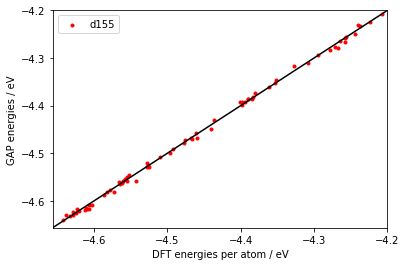

In [41]:
dfig, dax = plt.subplots()
energy_error(d155, ax=dax, by_config=False, color='r', rmse=False, label='d155')
energy_error(d155_v, ax=dax, by_config=False, color='b', rmse=False, label='d155_v')
energy_error(d155_ve4, ax=dax, by_config=False, color='g', rmse=False, label='d155_ve')
dax.text(-4.65, -4.5, 'E RMSE Stdev / meV\n{0:6.3f}   {1:6.3f}\n{2:6.3f}   {3:6.3f}\n{4:6.3f}   {5:6.3f}'.format(
    np.average([i['rmse']*1000 for i in d155.data_dict['E_rmse_v']]),
    np.average([i['std']*1000 for i in d155.data_dict['E_rmse_v']]),
    np.average([i['rmse']*1000 for i in d155_v.data_dict['E_rmse_v']]),
    np.average([i['std']*1000 for i in d155_v.data_dict['E_rmse_v']]),
    np.average([i['rmse']*1000 for i in d155_ve4.data_dict['E_rmse_v']]),
    np.average([i['std']*1000 for i in d155_ve4.data_dict['E_rmse_v']])))
dfig.savefig('/Users/Moji/Documents/Summer20/Ge/Analysis/energy_errors.png')

In [ ]:
d155.calc_similarity()

In [ ]:
similarity_map(d155)

In [3]:
d155_ve4 = GAP(train_file, val_file, pot_ve4)

NameError: name 'GAP' is not defined

In [ ]:
d155_ve4.calc()
d155_ve4.analyse(train=True, sorted_order=[0,3,4,1,2])

In [ ]:
d155_ve4.save('/Users/Moji/Documents/Summer20/Ge/Pickles/d155_ve4')

In [ ]:
d155

In [2]:
from ase import units
from ase.md.npt import NPT
import time
from ase.io.lammpsdata import read_lammps_data

In [25]:
potdir = '/Users/Moji/Documents/Summer20/Ge/Potentials/'
pot = Potential(param_filename=potdir+'as75_ds002_vF/as75_ds002_vF.xml')

In [3]:
dia = ase.Atoms(build.bulk('Ge', crystalstructure='diamond', cubic=True))
dia_s = build.make_supercell(dia, [[2, 0, 0],
                                  [0, 2, 0],
                                  [0, 0, 2]])

In [20]:
dia_s = read_lammps_data('/Users/Moji/Documents/Summer20/Ge/MD_runs/ase_MD/rnd_64001.data', style="atomic")

In [27]:
dia_s.set_atomic_numbers([32 for i in range(64)])

In [28]:
dia_s.set_calculator(pot)
sT = 2500*units.kB
fT = 300*units.kB
Ts = [sT - i*(sT-fT)/4 for i in range(5)]
print(np.array(Ts)/units.kB)
dyn = NPT(dia_s, 1*units.fs, sT, 0, 25, 3375)

[2500. 1950. 1400.  850.  300.]


In [30]:
traj = Trajectory('Ge_NPT_test.traj', 'w', dia_s)
dyn.attach(MDLogger_NPT(dyn, dia_s, '-', header=True, stress=True, peratom=True, mode="a"), interval=10)
dyn.attach(traj.write, interval=50)
meltsteps=50
quenchsteps = 50
st = time.time()
dyn.run(meltsteps)
for i in range(len(Ts)):
    dyn.set_temperature(Ts[i])
    dyn.run(quenchsteps//len(Ts))
print('----- run time = %6.2f' % (time.time() - st))

Time[ps]    Etot/N[eV]   Epot/N[eV]   Ekin/N[eV]  Volume[A^3]          MSD       P[GPa]    T[K]      ---------------------- stress [GPa] -----------------------
0.0100       -2536.6911   -2536.7457       0.0545    1497.5450       0.0000       0.4166  422.0     -0.830     -0.798     -1.210      1.589      1.645     -0.786
0.0200       -2536.6907   -2536.8380       0.1472    1497.5575       0.0000      -0.5578 1138.8     -0.003      0.475      0.142      1.059      1.324     -0.355
0.0300       -2536.6897   -2536.8975       0.2078    1497.5684       0.0000      -1.5388 1607.3      0.868      1.621      1.398      0.729      1.031     -0.014
0.0400       -2536.6882   -2536.9225       0.2343    1497.5693       0.0000      -2.0304 1812.9      1.312      2.169      1.989      0.622      0.950      0.217
0.0500       -2536.6864   -2536.9259       0.2395    1497.5559       0.0000      -2.1002 1852.8      1.300      2.253      2.154      0.593      0.926      0.456
0.0600       -2536.6845   -25

In [24]:
75**2 * 0.6


3375.0

In [29]:
dia_s.get_potential_energy()


-162348.2311701055

In [12]:
class MDLogger_NPT:
    """Class for logging molecular dynamics simulations.

    Parameters:
    dyn:           The dynamics.  Only a weak reference is kept.

    atoms:         The atoms.

    logfile:       File name or open file, "-" meaning standard output.

    stress=False:  Include stress in log.

    peratom=False: Write energies per atom.

    mode="a":      How the file is opened if logfile is a filename.
    """
    def __init__(self, dyn, atoms, logfile, header=True, stress=False,
                 peratom=False, mode="a"):
        import ase.parallel
        import weakref
        import sys
        if ase.parallel.world.rank > 0:
            logfile="/dev/null"  # Only log on master
        if hasattr(dyn, "get_time"):
            self.dyn = weakref.proxy(dyn)
        else:
            self.dyn = None
        self.atoms = atoms
        global_natoms = atoms.get_global_number_of_atoms()
        if logfile == "-":
            self.logfile = sys.stdout
            self.ownlogfile = False
        elif hasattr(logfile, "write"):
            self.logfile = logfile
            self.ownlogfile = False
        else:
            self.logfile = open(logfile, mode, 1)
            self.ownlogfile = True
        self.stress = stress
        self.peratom = peratom
        if self.dyn is not None:
            self.hdr = "%-9s " % ("Time[ps]",)
            self.fmt = "%-10.4f "
        else:
            self.hdr = ""
            self.fmt = ""
        if self.peratom:
            self.hdr += "%12s %12s %12s %12s %12s %12s  %6s" % ("Etot/N[eV]", "Epot/N[eV]",
                                                 "Ekin/N[eV]", "Volume[A^3]", "MSD", "P[GPa]", "T[K]")
            self.fmt += "%12.4f %12.4f %12.4f %12.4f %12.4f %12.4f %6.1f"
        else:
            self.hdr += "%12s %12s %12s   %6s" % ("Etot[eV]", "Epot[eV]",
                                                 "Ekin[eV]", "T[K]")
            # Choose a sensible number of decimals
            if global_natoms <= 100:
                digits = 4
            elif global_natoms <= 1000:
                digits = 3
            elif global_natoms <= 10000:
                digits = 2
            else:
                digits = 1
            self.fmt += 3*("%%12.%df " % (digits,)) + " %6.1f"
        if self.stress:
            self.hdr += "      ---------------------- stress [GPa] -----------------------"
            self.fmt += 6*" %10.3f"
        self.fmt += "\n"
        if header:
            self.logfile.write(self.hdr+"\n")

    def __del__(self):
        self.close()

    def close(self):
        if self.ownlogfile:
            self.logfile.close()

    def __call__(self):
        epot = self.atoms.get_potential_energy()
        ekin = self.atoms.get_kinetic_energy()
        global_natoms = self.atoms.get_global_number_of_atoms()
        temp = ekin / (1.5 * units.kB * global_natoms)
        vol = self.atoms.get_volume()
        stress = tuple(self.atoms.get_stress(include_ideal_gas=True) / units.GPa)
        press = -sum(stress[:4])/3
        msd = 0.0
        if self.peratom:
            epot /= global_natoms
            ekin /= global_natoms
        if self.dyn is not None:
            t = self.dyn.get_time() / (1000*units.fs)
            dat = (t,)
        else:
            dat = ()
        dat += (epot+ekin, epot, ekin, vol, msd, press, temp)
        if self.stress:
            dat += tuple(self.atoms.get_stress(include_ideal_gas=True) / units.GPa)
        self.logfile.write(self.fmt % dat)
        self.logfile.flush()

In [7]:
d155_ve4 = GAP(train_file, val_file, pot_ve4)
d155_ve4.load('/Users/Moji/Documents/Summer20/Ge/Pickles/d155_ve4')

Training set structure count: 281
Validation set structure count: 70
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']
Load successful
data_dict:  dict_keys(['QM_E_t', 'QM_F_t', 'QM_V_t', 'GAP_E_t', 'GAP_F_t', 'GAP_V_t', 'E_err_t', 'F_err_t', 'V_err_t', 'E_rmse_t', 'F_rmse_t', 'V_rmse_t', 'QM_E_v', 'QM_F_v', 'QM_V_v', 'GAP_E_v', 'GAP_F_v', 'GAP_V_v', 'E_err_v', 'F_err_v', 'V_err_v', 'E_rmse_v', 'F_rmse_v', 'V_rmse_v'])


In [8]:
f_GV = [np.reshape(t := np.array(d155_ve4.data_dict['GAP_F_v'][i]),
                    (len(t)//3, 3)) for i in range(5)]

In [9]:
f_QV = [np.reshape(np.array(t := d155_ve4.data_dict['QM_F_v'][i]),
                                       (len(t)//3, 3)) for i in range(5)]


In [10]:
mag_G = [np.linalg.norm(i, axis=1) for i in f_GV]
mag_Q = [np.linalg.norm(i, axis=1) for i in f_QV]

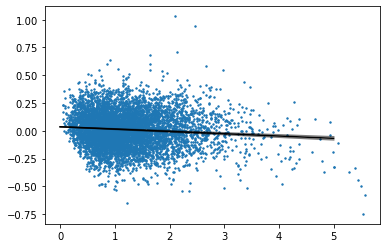

In [25]:
fig, axs = plt.subplots()
axs.scatter(Q := flatten(mag_Q), ferr := np.array(flatten([mag_G[i] - mag_Q[i] for i in range(len(mag_G))])),  s=2)
lin = list(sci.stats.linregress(Q, ferr))
axs.plot(x := np.linspace(0,5,100), lin[0]*x + lin[1], color='k', zorder=1)
axs.plot(x, (lin[0]+lin[-1])*x + lin[1], color='k', zorder=1, alpha=0.3)
axs.plot(x, (lin[0]-lin[-1])*x + lin[1], color='k', zorder=1, alpha=0.3)

In [24]:
sci.stats.linregress(Q, ferr)

LinregressResult(slope=-0.020792980232640663, intercept=0.03620412954303435, rvalue=-0.09102176695837612, pvalue=1.6039158061639204e-13, stderr=0.0028121810846007864)

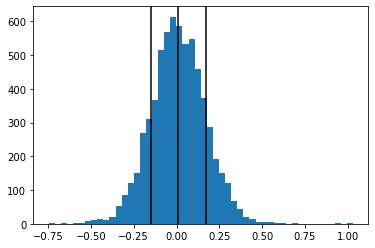

In [78]:
fig, axs = plt.subplots()
axs.hist(np.array(t := flatten([mag_G[i] - mag_Q[i] for i in range(len(mag_G))])), bins=50, zorder=0.5)
axs.axvline(av := np.average(t), color='k', zorder=1)
axs.axvline(np.std(t) + av, zorder=1, color='k')
axs.axvline(-np.std(t) + av, zorder = 1, color='k')

In [18]:
'''validation factory here: create GAP objects for all of the potentials tested with Volker,
save for future use (consider doing this on the cluster) and begin statistical analysis of the
forces to see if we can find a correlation between good/poor behaviour. First for liquids, then for
amorphous.'''
param_explore = '/Users/Moji/Documents/Summer20/Ge/Potentials/parameter_explore/'
pots = [Potential(param_filename=(param_explore + i)) for i in os.listdir(param_explore) if i[-3:] == 'xml']
pots

In [22]:
GAPS = [GAP(train_file, val_file, pot=i) for i in pots]


Training set structure count: 281
Validation set structure count: 70
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']
Training set structure count: 281
Validation set structure count: 70
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']
Training set structure count: 281
Validation set structure count: 70
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']
Training set structure count: 281
Validation set structure count: 70
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']
Training set structure count: 281
Validation set structure count: 70
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amorph', 'inter']
Training set structure count: 281
Validation set structure count: 70
Read configs, now fixing virials
Config labels: ['amorph', 'liq', 'hiT_liq', 'hiT_amor

In [26]:
for i in GAPS:
    i.calc()

Config amorph done
Config liq done
Config hiT_liq done
Config hiT_amorph done
Config inter done
Config amorph done
Config liq done
Config hiT_liq done
Config hiT_amorph done
Config inter done
--- 606.0859799385071 seconds ---
Config amorph done
Config liq done
Config hiT_liq done
Config hiT_amorph done
Config inter done
Config amorph done
Config liq done
Config hiT_liq done
Config hiT_amorph done
Config inter done
--- 517.1069350242615 seconds ---
Config amorph done
Config liq done
Config hiT_liq done
Config hiT_amorph done
Config inter done
Config amorph done
Config liq done
Config hiT_liq done
Config hiT_amorph done
Config inter done
--- 500.55546283721924 seconds ---
Config amorph done
Config liq done
Config hiT_liq done
Config hiT_amorph done
Config inter done
Config amorph done
Config liq done
Config hiT_liq done
Config hiT_amorph done
Config inter done
--- 525.7846360206604 seconds ---
Config amorph done
Config liq done
Config hiT_liq done
Config hiT_amorph done
Config inter done

In [29]:
for i in GAPS:
    i.analyse(sorted_order=[0, 3, 4, 1, 2])

New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']
New order:  ['amorph', 'hiT_amorph', 'inter', 'liq', 'hiT_liq']


In [33]:
for i, val in enumerate(GAPS):
    val.save('/Users/Moji/Documents/Summer20/Ge/Pickles/GAPS/pot' + str(i))


In [34]:
f_GV = [[np.reshape(t := np.array(j.data_dict['GAP_F_v'][i]),
                    (len(t)//3, 3)) for i in range(5)] for j in GAPS]

In [35]:
f_QV = [[np.reshape(np.array(t := j.data_dict['QM_F_v'][i]),
                                       (len(t)//3, 3)) for i in range(5)] for j in GAPS]


In [36]:
mag_G = [[np.linalg.norm(i, axis=1) for i in j] for j in f_GV]
mag_Q = [[np.linalg.norm(i, axis=1) for i in j ] for j in f_QV]


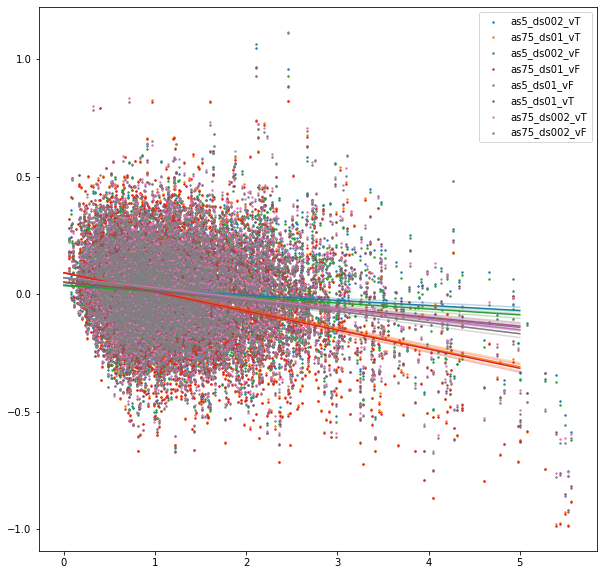

In [58]:
fig, axs = plt.subplots(figsize=(10,10))

for i, val in enumerate(GAPS):
    color = next(axs._get_lines.prop_cycler)['color']
    axs.scatter(Q := flatten(mag_Q[i]),
                ferr := np.array(flatten([mag_G[i][j] - mag_Q[i][j] for j in range(len(mag_G[i]))])),
                color=color, s=2, label=val.name)
    lin = list(sci.stats.linregress(Q, ferr))
    axs.plot(x := np.linspace(0,5,100), lin[0]*x + lin[1], zorder=1, color=color)
    axs.plot(x, (lin[0]+lin[-1])*x + lin[1], zorder=1, alpha=0.3, color=color)
    axs.plot(x, (lin[0]-lin[-1])*x + lin[1], zorder=1, alpha=0.3, color=color)
axs.legend()

In [55]:
a=0
for ct, i in enumerate(os.listdir(param_explore)):
    if i[-3:] == 'xml':
        GAPS[a].name = i[:-4]
        print(GAPS[a].name)
        a += 1

as5_ds002_vT
as75_ds01_vT
as5_ds002_vF
as75_ds01_vF
as5_ds01_vF
as5_ds01_vT
as75_ds002_vT
as75_ds002_vF


In [52]:
GAPS[0].pot.set_label

AttributeError: 'Potential' object has no attribute 'set_name'

In [60]:
GAPS[0].name

'as5_ds002_vT'

In [ ]:
with open('')
GAPS[0].data_dict

In [19]:

for i in flatten(d155_v.T_configs):
    i.set_calculator(d155_v.pot)

In [17]:
a = 160.22*np.average([np.trace(flatten(d155_v.data_dict['QM_V_t'])[i])/(3*flatten(d155_v.T_configs)[i].get_volume()) for i in range(len(d155_v.data_dict['QM_V_t']))])
a

1.8790230852514345

In [20]:
print('hi')

hi


In [18]:
len(flatten(d155_v.data_dict['QM_V_t']))

280

In [14]:
20/1000*160


0.32

In [15]:
len(flatten(d155_v.T_configs))


280